**Общая информация**

**Срок сдачи:** 18 октября 2017, 06:00 <br\>
**Штраф за опоздание:** -2 балла после 06:00 18 октября, -4 балла после 06:00 25 октября, -6 баллов после 06:00 1 ноября

При отправлении ДЗ указывайте фамилию в названии файла
Присылать ДЗ необходимо в виде ссылки на свой github репозиторий в slack @alkhamush

Необходимо в slack создать таск в приватный чат:
/todo Фамилия Имя ссылка на гитхаб @alkhamush
Пример:
/todo Ксения Стройкова https://github.com/stroykova/spheremailru/stroykova_hw1.ipynb @alkhamush
Дополнительно нужно просто скинуть ссылку в slack в личный чат

Используйте данный Ipython Notebook при оформлении домашнего задания.

###### Задание 1 (2 баллов)
Реализовать KNN в классе MyKNeighborsClassifier (обязательное условие: точность не ниже sklearn реализации)
Разберитесь самостоятельно, какая мера расстояния используется в KNeighborsClassifier дефолтно и реализуйте свой алгоритм именно с этой мерой. Самостоятельно разберитесь, как считается score из KNeighborsClassifier и реализуйте аналог в своём классе. Score не должен уступать значению KNN из sklearn

###### Задание 2 (2 балла)
Добиться скорости работы на fit,  predict и predict_proba сравнимой со sklearn для iris и mnist
Для этого используем numpy

###### Задание 3 (2 балла)
Для iris найдите такой параметр n_neighbors, при котором выдаётся наилучший score. Нарисуйте график зависимости score от n_neighbors

###### Задание 4 (3 балла)
Добавить algorithm='kd_tree' в реализацию KNN (использовать KDTree из sklearn.neighbors). Значение n_neighbors нужно взять из задания 3. Добиться скорости работы на fit,  predict и predict_proba сравнимой со sklearn для iris и mnist
Для этого используем numpy. Score не должен уступать значению KNN из sklearn

###### Задание 5 (1 балла)
Описать для чего нужны следующие библиотеки/классы/функции (список будет ниже)

**Штрафные баллы:**

1. Невыполнение PEP8 -1 балл
2. Отсутствие фамилии в имени скрипта (скрипт должен называться по аналогии со stroykova_hw1.ipynb) -1 балл
3. Все строчки должны быть выполнены. Нужно, чтобы output команды можно было увидеть уже в git'е. В противном случае -1 балл
4. При оформлении ДЗ нужно пользоваться данным файлом в качестве шаблона. Не нужно удалять и видоизменять структуру кода и текст. В противном случае -1 балл


In [2]:
import numpy as np
import matplotlib.pyplot as plt

import seaborn as sns
from sklearn import datasets
from sklearn.base import ClassifierMixin
from sklearn.datasets import fetch_mldata
from sklearn.neighbors.base import NeighborsBase, KNeighborsMixin, SupervisedIntegerMixin 
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import KDTree
import collections
%load_ext pycodestyle_magic

In [12]:
#%%pycodestyle


class MyKNeighborsClassifier(NeighborsBase, KNeighborsMixin,
                             SupervisedIntegerMixin, ClassifierMixin):

    def __init__(self, n_neighbors, algorithm='brute'):
        self.n_neighbors = n_neighbors
        self.algorithm = algorithm

    def fit(self, X, y):
        self.X_train = X
        self.y_train = y
        self.N_class = int(np.amax(y) + 1)
        self.train_size = X.shape[0]
        if self.algorithm is 'kd_tree':
            self.X_tree = KDTree(self.X_train)

    def predict(self, X):
        if self.algorithm is 'brute':
            return self._predict_brute(X)
        elif self.algorithm is 'kd_tree':
            return self._predict_kd_tree(X)

    def predict_proba(self, X):
        if self.algorithm is 'brute':
            return self._predict_proba_brute(X)
        elif self.algorithm is 'kd_tree':
            return self._predict_proba_kd_tree(X)

    def score(self, X, y):
        return np.sum(y == self.predict(X)) / len(y)

    def _predict_on_class(self, pred_size, nearest_class):
        ans = np.zeros(pred_size)
        for ind in range(pred_size):
            cnt = collections.Counter(nearest_class[ind])
            ans[ind] = cnt.most_common(1)[0][0]
        return ans.astype(int)

    def _predict_proba_on_class(self, pred_size, nearest_class):
        ans = np.zeros((pred_size, self.N_class))
        for ind in range(pred_size):
            cnt = collections.Counter(nearest_class[ind])
            com_cnt = cnt.most_common(self.N_class)
            for item in com_cnt:
                ans[ind][int(item[0])] = item[1] / self.n_neighbors
        return ans

    def _predict_brute(self, X):
        pred_size = X.shape[0]
        nearest_class = self._find_nearest_brute(X)
        return self._predict_on_class(pred_size, nearest_class)

    def _predict_proba_brute(self, X):
        pred_size = X.shape[0]
        nearest_class = self._find_nearest_brute(X)
        return self._predict_proba_on_class(pred_size, nearest_class)

    def _find_nearest_brute(self, X):
        X_train = np.array(self.X_train).astype(float)
        X_pred = np.array(X).astype(float)

        X_train_sq = np.sum(X_train ** 2, axis=1).reshape(1, -1)
        X_pred_sq = np.sum(X_pred ** 2, axis=1).reshape(-1, 1)
        cross_X = np.matmul(X_pred, X_train.T)
        dist = np.sqrt(X_pred_sq - 2 * cross_X + X_train_sq)

        sort_n_ind = np.argpartition(dist, (range(self.n_neighbors)), axis=1)
        return y_train[sort_n_ind[:, :self.n_neighbors]]

    def _predict_kd_tree(self, X):
        pred_size = X.shape[0]
        nearest_class = self._find_nearest_kd_tree(X)
        return self._predict_on_class(pred_size, nearest_class)

    def _predict_proba_kd_tree(self, X):
        pred_size = X.shape[0]
        nearest_class = self._find_nearest_kd_tree(X)
        return self._predict_proba_on_class(pred_size, nearest_class)

    def _find_nearest_kd_tree(self, X):
        X_pred = np.array(X).astype(float)
        sort_n_ind = self.X_tree.query(X_pred, k=self.n_neighbors)[1]
        return y_train[sort_n_ind[:, :self.n_neighbors]]

**IRIS**

In [3]:
iris = datasets.load_iris()

In [4]:
X_train, X_test, y_train, y_test = train_test_split(
    iris.data, iris.target,
    test_size=0.1, stratify=iris.target)

In [5]:
clf = KNeighborsClassifier(n_neighbors=2, algorithm='brute')
my_clf = MyKNeighborsClassifier(n_neighbors=2, algorithm='brute')

In [6]:
%time clf.fit(X_train, y_train)

CPU times: user 0 ns, sys: 1.45 ms, total: 1.45 ms
Wall time: 1.33 ms


KNeighborsClassifier(algorithm='brute', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=2, p=2,
           weights='uniform')

In [7]:
%time my_clf.fit(X_train, y_train)

CPU times: user 60 µs, sys: 11 µs, total: 71 µs
Wall time: 76.8 µs


In [8]:
%time clf.predict(X_test)

CPU times: user 3.94 ms, sys: 701 µs, total: 4.64 ms
Wall time: 79.7 ms


array([2, 2, 1, 2, 2, 0, 1, 1, 2, 1, 0, 0, 1, 0, 0])

In [9]:
%time my_clf.predict(X_test)

CPU times: user 4.64 ms, sys: 0 ns, total: 4.64 ms
Wall time: 4.18 ms


array([2, 2, 1, 2, 2, 0, 1, 1, 2, 1, 0, 0, 1, 0, 0])

In [10]:
%time clf.predict_proba(X_test)

CPU times: user 1.18 ms, sys: 0 ns, total: 1.18 ms
Wall time: 887 µs


array([[0., 0., 1.],
       [0., 0., 1.],
       [0., 1., 0.],
       [0., 0., 1.],
       [0., 0., 1.],
       [1., 0., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 0., 1.],
       [0., 1., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [0., 1., 0.],
       [1., 0., 0.],
       [1., 0., 0.]])

In [11]:
%time my_clf.predict_proba(X_test)

CPU times: user 1.13 ms, sys: 0 ns, total: 1.13 ms
Wall time: 749 µs


array([[0., 0., 1.],
       [0., 0., 1.],
       [0., 1., 0.],
       [0., 0., 1.],
       [0., 0., 1.],
       [1., 0., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 0., 1.],
       [0., 1., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [0., 1., 0.],
       [1., 0., 0.],
       [1., 0., 0.]])

In [12]:
clf.score(X_test, y_test)

1.0

In [13]:
my_clf.score(X_test, y_test)

1.0

Задание 3

Best result on 17


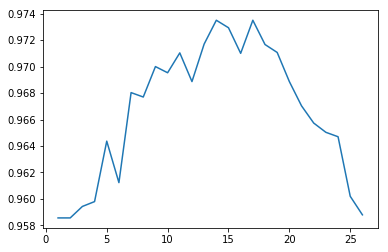

In [14]:
#%%pycodestyle


N_tests = 2000
bound_neigh = my_clf.train_size // 5

y = np.zeros((bound_neigh - 1, N_tests))
for test in range(N_tests):
    X_train, X_test, y_train, y_test = train_test_split(
        iris.data, iris.target, test_size=0.1,
        stratify=iris.target)

    for i in range(1, bound_neigh):
        iter_clf = MyKNeighborsClassifier(n_neighbors=i)
        iter_clf.fit(X_train, y_train)
        y[i - 1][test] = iter_clf.score(X_test, y_test)


x = np.arange(1, bound_neigh)
y = np.mean(y, axis=1)
plt.plot(x, y)

max_eff = np.argpartition(y, -1)[-1] + 1
print(f"Best result on {max_eff}")

**MNIST**

In [4]:
mnist = fetch_mldata('MNIST original')

/home/george/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function fetch_mldata is deprecated; fetch_mldata was deprecated in version 0.20 and will be removed in version 0.22
  warnings.warn(msg, category=DeprecationWarning)
/home/george/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function mldata_filename is deprecated; mldata_filename was deprecated in version 0.20 and will be removed in version 0.22
  warnings.warn(msg, category=DeprecationWarning)


In [5]:
X_train, X_test, y_train, y_test = train_test_split(
    mnist.data, mnist.target,
    test_size=0.01, stratify=mnist.target)

In [6]:
clf = KNeighborsClassifier(n_neighbors=2, algorithm='brute')
my_clf = MyKNeighborsClassifier(n_neighbors=2, algorithm='brute')

In [7]:
%time clf.fit(X_train, y_train)

CPU times: user 10.1 ms, sys: 285 µs, total: 10.4 ms
Wall time: 10.1 ms


KNeighborsClassifier(algorithm='brute', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=2, p=2,
           weights='uniform')

In [8]:
%time my_clf.fit(X_train, y_train)

CPU times: user 162 µs, sys: 26 µs, total: 188 µs
Wall time: 209 µs


In [9]:
%time clf.predict(X_test)

CPU times: user 3.47 s, sys: 463 ms, total: 3.94 s
Wall time: 2.37 s


array([4., 3., 9., 3., 9., 5., 6., 5., 0., 4., 3., 7., 9., 4., 3., 7., 9.,
       1., 9., 4., 5., 4., 1., 7., 4., 6., 3., 3., 5., 6., 1., 1., 7., 7.,
       0., 0., 2., 3., 0., 4., 9., 0., 4., 0., 4., 3., 4., 2., 4., 5., 4.,
       2., 8., 5., 7., 3., 8., 1., 7., 5., 5., 2., 2., 2., 7., 8., 1., 4.,
       4., 9., 5., 7., 5., 8., 0., 5., 6., 9., 4., 2., 5., 7., 1., 5., 2.,
       3., 0., 2., 8., 0., 6., 2., 4., 2., 3., 9., 5., 2., 8., 6., 8., 4.,
       7., 3., 0., 3., 0., 1., 0., 3., 8., 7., 2., 6., 1., 3., 7., 0., 0.,
       0., 0., 5., 9., 8., 1., 6., 6., 1., 9., 2., 2., 2., 6., 1., 3., 3.,
       6., 3., 9., 6., 8., 4., 5., 5., 9., 8., 7., 1., 9., 2., 6., 1., 4.,
       6., 9., 4., 6., 0., 1., 8., 2., 3., 2., 1., 3., 8., 1., 8., 0., 4.,
       5., 9., 7., 6., 1., 1., 8., 0., 8., 5., 4., 9., 9., 1., 2., 6., 7.,
       3., 1., 3., 3., 2., 5., 0., 6., 9., 6., 6., 7., 1., 2., 2., 8., 9.,
       5., 3., 9., 6., 7., 3., 7., 3., 5., 3., 0., 1., 1., 3., 7., 7., 2.,
       7., 5., 2., 1., 0.

In [10]:
%time my_clf.predict(X_test)

CPU times: user 4.29 s, sys: 1.35 s, total: 5.64 s
Wall time: 3.06 s


array([4, 3, 9, 3, 9, 5, 6, 5, 0, 4, 3, 7, 9, 4, 3, 7, 9, 1, 9, 4, 5, 4,
       1, 7, 4, 6, 3, 3, 5, 6, 1, 1, 7, 7, 0, 0, 2, 3, 0, 4, 9, 0, 4, 0,
       4, 3, 4, 2, 4, 5, 4, 2, 8, 5, 7, 3, 8, 1, 7, 5, 5, 2, 2, 2, 7, 8,
       1, 4, 4, 9, 5, 7, 5, 8, 0, 5, 6, 9, 4, 2, 5, 7, 1, 5, 2, 3, 0, 2,
       8, 0, 6, 2, 4, 2, 3, 9, 5, 2, 8, 6, 8, 4, 7, 3, 0, 3, 0, 1, 0, 3,
       8, 7, 2, 6, 1, 7, 7, 0, 0, 0, 0, 5, 9, 8, 1, 6, 6, 1, 9, 2, 2, 2,
       6, 1, 3, 3, 6, 3, 9, 6, 8, 9, 5, 5, 9, 8, 7, 1, 9, 2, 6, 1, 4, 6,
       9, 4, 6, 0, 1, 8, 2, 3, 2, 1, 3, 8, 1, 8, 0, 4, 5, 9, 7, 6, 1, 1,
       8, 0, 8, 5, 4, 9, 9, 1, 2, 6, 7, 3, 1, 3, 3, 2, 5, 0, 6, 9, 6, 6,
       7, 1, 2, 2, 8, 9, 5, 3, 9, 6, 7, 3, 7, 3, 5, 3, 0, 1, 1, 3, 7, 7,
       2, 7, 5, 2, 1, 0, 2, 5, 1, 3, 1, 2, 1, 1, 6, 8, 3, 1, 3, 2, 1, 9,
       8, 2, 5, 5, 4, 2, 9, 3, 3, 5, 4, 5, 7, 6, 0, 6, 8, 9, 2, 2, 3, 0,
       3, 8, 1, 0, 9, 2, 2, 2, 8, 3, 6, 3, 9, 3, 7, 6, 4, 0, 5, 3, 5, 6,
       0, 8, 7, 1, 9, 1, 6, 4, 2, 3, 6, 0, 7, 1, 2,

In [22]:
%time clf.predict_proba(X_test)

CPU times: user 3.56 s, sys: 473 ms, total: 4.04 s
Wall time: 4.16 s


array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.]])

In [23]:
%time my_clf.predict_proba(X_test)

CPU times: user 4.33 s, sys: 1.25 s, total: 5.58 s
Wall time: 3.47 s


array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.]])

In [24]:
clf.score(X_test, y_test)

0.9757142857142858

In [25]:
my_clf.score(X_test, y_test)

0.98

Задание 4

In [26]:
clf = KNeighborsClassifier(n_neighbors=max_eff, algorithm='kd_tree')
my_clf = MyKNeighborsClassifier(n_neighbors=max_eff, algorithm='kd_tree')

In [27]:
X_train, X_test, y_train, y_test = train_test_split(
    mnist.data, mnist.target,
    test_size=0.01, stratify=mnist.target)

In [28]:
%time clf.fit(X_train, y_train)

CPU times: user 1min 15s, sys: 303 ms, total: 1min 15s
Wall time: 1min 16s


KNeighborsClassifier(algorithm='kd_tree', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=17, p=2,
           weights='uniform')

In [29]:
%time my_clf.fit(X_train, y_train)

CPU times: user 1min 9s, sys: 331 ms, total: 1min 9s
Wall time: 1min 9s


In [30]:
%time clf.predict(X_test)

CPU times: user 1min 24s, sys: 18.6 ms, total: 1min 24s
Wall time: 1min 24s


array([2., 1., 9., 9., 1., 5., 4., 5., 7., 2., 3., 3., 8., 5., 4., 3., 1.,
       3., 9., 7., 8., 0., 0., 3., 4., 3., 7., 4., 3., 5., 5., 5., 0., 1.,
       7., 9., 6., 7., 4., 9., 5., 1., 0., 1., 7., 0., 6., 7., 1., 9., 6.,
       2., 5., 5., 5., 8., 0., 0., 6., 7., 1., 2., 2., 3., 1., 3., 0., 9.,
       9., 1., 9., 3., 6., 6., 1., 5., 2., 9., 5., 7., 6., 1., 4., 6., 0.,
       6., 5., 0., 9., 9., 0., 7., 5., 3., 9., 0., 5., 6., 0., 5., 7., 4.,
       3., 7., 3., 4., 1., 5., 4., 2., 4., 1., 3., 6., 6., 3., 8., 0., 2.,
       4., 7., 1., 0., 2., 3., 4., 0., 6., 3., 9., 5., 7., 8., 6., 0., 8.,
       9., 1., 6., 9., 7., 8., 1., 3., 9., 2., 9., 1., 9., 6., 6., 7., 2.,
       1., 5., 8., 4., 7., 8., 3., 2., 2., 1., 8., 0., 6., 7., 2., 3., 7.,
       5., 1., 4., 3., 3., 3., 5., 8., 5., 4., 5., 8., 3., 6., 4., 3., 7.,
       0., 7., 5., 8., 5., 1., 3., 1., 1., 1., 8., 0., 7., 7., 4., 6., 6.,
       8., 4., 2., 2., 2., 7., 2., 9., 3., 5., 9., 0., 9., 0., 4., 9., 0.,
       8., 6., 8., 9., 1.

In [31]:
%time my_clf.predict(X_test)

CPU times: user 1min 10s, sys: 11.3 ms, total: 1min 10s
Wall time: 1min 10s


array([2, 1, 9, 9, 1, 5, 4, 5, 7, 2, 3, 3, 8, 5, 4, 3, 1, 3, 9, 7, 8, 0,
       0, 8, 4, 3, 7, 4, 3, 5, 5, 5, 0, 1, 7, 9, 6, 7, 4, 9, 5, 1, 0, 1,
       7, 0, 6, 7, 1, 9, 6, 2, 5, 5, 5, 8, 0, 0, 6, 7, 1, 2, 2, 3, 1, 3,
       0, 9, 9, 1, 9, 3, 6, 6, 1, 5, 2, 9, 5, 7, 6, 1, 4, 6, 0, 6, 5, 0,
       9, 9, 0, 7, 5, 3, 9, 0, 5, 6, 0, 5, 7, 4, 3, 7, 3, 4, 1, 5, 4, 2,
       4, 1, 3, 6, 6, 3, 8, 0, 2, 4, 7, 1, 0, 2, 3, 4, 0, 6, 3, 9, 5, 7,
       8, 6, 0, 8, 9, 1, 6, 9, 7, 8, 1, 3, 9, 2, 9, 1, 9, 6, 6, 7, 2, 1,
       5, 8, 4, 7, 8, 3, 2, 2, 1, 8, 0, 6, 7, 2, 3, 7, 5, 1, 4, 3, 3, 3,
       5, 8, 5, 4, 5, 8, 3, 6, 4, 3, 7, 0, 7, 5, 8, 5, 1, 3, 1, 1, 1, 8,
       0, 7, 7, 4, 6, 6, 8, 4, 2, 2, 2, 7, 2, 9, 3, 5, 9, 0, 9, 0, 4, 9,
       0, 8, 6, 8, 9, 1, 2, 0, 7, 0, 9, 3, 3, 3, 2, 2, 3, 3, 6, 8, 8, 7,
       4, 1, 4, 9, 6, 1, 6, 0, 8, 1, 1, 7, 2, 7, 0, 6, 3, 4, 4, 1, 9, 4,
       9, 3, 1, 3, 6, 1, 3, 1, 9, 0, 3, 7, 4, 5, 9, 8, 6, 1, 1, 1, 6, 1,
       9, 1, 1, 4, 9, 4, 7, 8, 5, 0, 0, 0, 3, 9, 8,

In [32]:
%time clf.predict_proba(X_test)

CPU times: user 1min 24s, sys: 19.4 ms, total: 1min 24s
Wall time: 1min 24s


array([[0., 0., 1., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 1.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [33]:
%time my_clf.predict_proba(X_test)

CPU times: user 1min 7s, sys: 7.65 ms, total: 1min 7s
Wall time: 1min 7s


array([[0., 0., 1., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 1.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [34]:
clf.score(X_test, y_test)

0.9585714285714285

In [35]:
my_clf.score(X_test, y_test)

0.96

Задание 5

In [36]:
# seaborn -- высокоуровневая библиотека для визуализации данных, основанная на matplotlib
# matplotlib -- библиотека для визуализации двумерных данных
# train_test_split -- функция рандомизированного деления данных на тренировочные и проверочные
# Pipelin%load_ext e (from sklearn.pipeline import Pipeline) -- класс для последовательного преобразования данных
# StandardScaler (from sklearn.preprocessing import StandardScaler) -- класс для стандартизации данных
# ClassifierMixin -- класс-примесь для классификаторов scikit-learn
# NeighborsBase -- базовый класс для классификации по соседям
# KNeighborsMixin -- базовый класс для поиска K ближайших соседей
# SupervisedIntegerMixin -- базовый класс для метода fit